In [354]:
import numpy as np

num_trials = 10000

def create_random_config(N):
    """Create spin configuration of NxN lattice"""
    return 2 * np.random.randint(2, size=(N, N)) - 1

# better way:
# https://tanyaschlusser.github.io/posts/mcmc-and-the-ising-model/
def get_dH(lattice, trial_location):
    """ H = - Sum_<ij>(s_i s_j) """
    i, j = trial_location
    N, _ = lattice.shape
    H, Hflip = 0, 0
    for di, dj in ((-1, 0), (1, 0), (0, -1), (0, 1)):
        ii = (i + di) % N
        jj = (j + dj) % N
        H -= lattice[ii, jj] * lattice[i, j]
        Hflip += lattice[ii, jj] * lattice[i, j]
    return Hflip - H

def neighbours_sum(lattice, loc):
    i, j = loc
    N, _ = lattice.shape
    up = (i, (j-1)%N)
    left = ((i-1)%N, j)
    right = ((i+1)%N, j)
    down = (i, (j+1)%N)
    return lattice[up] + lattice[down] + lattice[left] + lattice[right]

def step(lattice, T):
    # Pick a random position in a lattice
    (N, _) = lattice.shape
    indices = np.random.randint(0, high=N, size=2)
    i, j = indices[0], indices[1]
    
    dH = get_dH(lattice, (i, j))
    
    maybe_flip(lattice, dH, (i, j), T)
    return lattice

def maybe_flip(lattice, dH, loc, T):
    i, j = loc
    
    if dH < 0:
        lattice[i,j] = -lattice[i,j]
    elif np.random.rand() < np.exp(-dH / T):
            lattice[i, j] = -lattice[i,j]
    return lattice

def energy(config):
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            entry = config[i,j]
            nb = neighbours_sum(config, (i, j))
            energy += -nb*entry
    return energy/4.


def mag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag

config = create_random_config(N=10)
print(config)

[[-1 -1  1  1 -1 -1  1 -1  1  1]
 [ 1  1  1  1 -1  1 -1  1  1 -1]
 [ 1  1 -1 -1 -1  1  1  1 -1 -1]
 [ 1 -1  1 -1  1  1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1  1  1  1]
 [ 1 -1  1 -1 -1  1  1  1 -1 -1]
 [ 1 -1 -1  1 -1 -1  1 -1 -1 -1]
 [-1  1 -1 -1  1 -1 -1 -1  1  1]
 [ 1  1  1  1  1  1 -1  1 -1 -1]
 [ 1  1 -1 -1  1  1 -1 -1  1  1]]


In [358]:
energies = []
mags = []

for _ in range(num_trials):
    step(config, T=2.0)
    energies.append(energy(config))
    mags.append(mag(config))

print(config)

[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]


In [244]:
print(maybe_flip(config, dH=get_dH(config, (1, 1)), loc=(1,1), T=2.0))

[[ 1 -1  1 -1 -1  1  1  1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1  1 -1 -1  1]
 [-1 -1 -1 -1 -1  1  1 -1 -1 -1]
 [ 1 -1  1 -1  1  1 -1  1 -1 -1]
 [ 1  1  1 -1 -1  1  1  1  1 -1]
 [ 1  1  1 -1 -1  1 -1 -1 -1  1]
 [-1  1 -1  1  1 -1 -1 -1  1  1]
 [-1  1  1 -1  1  1  1  1  1 -1]
 [ 1  1 -1  1  1  1  1 -1  1 -1]]


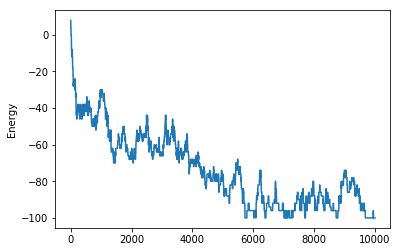

In [363]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(energies)
plt.ylabel('Energy')
plt.show()

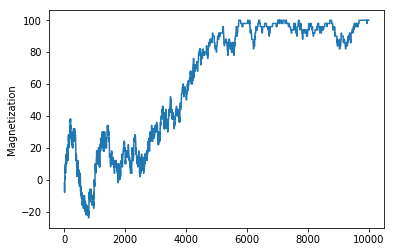

In [365]:
plt.plot(mags)
plt.ylabel('Magnetization')
plt.show()